In [1]:
import os
from DUAO.src import calibration, photometry, utils
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import median_filter

# Data reduction

In [2]:
asteroids_dir = os.path.join(utils.C2PU_DATA_DIR, utils.DIR_PHOTOM, utils.DIR_ASTER)
asteroids_dir = os.path.join(asteroids_dir, os.listdir(asteroids_dir)[0])
sorted(os.listdir(asteroids_dir))

['9-Metis_20231115T011656474_SC__0000s300_000000.fits',
 '9-Metis_20231115T011759878_SC__0000s300_000000.fits',
 '9-Metis_20231115T011903081_SC__0000s300_000000.fits',
 '9-Metis_20231115T012006353_SC__0000s300_000000.fits',
 '9-Metis_20231115T012109648_SC__0000s300_000000.fits',
 '9-Metis_20231115T012212965_SC__0000s300_000000.fits',
 '9-Metis_20231115T012316288_SC__0000s300_000000.fits',
 '9-Metis_20231115T012419613_SC__0000s300_000000.fits',
 '9-Metis_20231115T012522968_SC__0000s300_000000.fits',
 '9-Metis_20231115T012626292_SC__0000s300_000000.fits',
 '9-Metis_20231115T012729496_SC__0000s300_000000.fits',
 '9-Metis_20231115T012832746_SC__0000s300_000000.fits',
 '9-Metis_20231115T012936057_SC__0000s300_000000.fits',
 '9-Metis_20231115T013039365_SC__0000s300_000000.fits',
 '9-Metis_20231115T013142669_SC__0000s300_000000.fits',
 '9-Metis_20231115T013245916_SC__0000s300_000000.fits',
 '9-Metis_20231115T013349126_SC__0000s300_000000.fits',
 '9-Metis_20231115T013452313_SC__0000s300_000000

In [3]:
fits_sci_image = os.path.join(asteroids_dir, sorted(os.listdir(asteroids_dir))[0])
fits_sci_image = os.path.abspath(fits_sci_image)
os.path.isfile(fits_sci_image)

True

In [4]:
calibration.get_infos_from_image(fits_sci_image)

SCIENCE (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T01:16:56+00:00 (0.3s exposure).


(datetime.datetime(2023, 11, 15, 1, 16, 56, tzinfo=datetime.timezone.utc),
 'C2PU/Omicron',
 'QHY600M',
 '',
 0.3,
 4800,
 3211)

In [5]:
bias_dir, darks_dir, flats_dir = utils.get_calib_dirs_photometry(fits_sci_image)
print(bias_dir, darks_dir, flats_dir)

/home/etudiant/Documents/Archives_C2PU/Photometry/CCD__BIAS_DARKS_FLATS/BIAS/QHY600 /home/etudiant/Documents/Archives_C2PU/Photometry/CCD__BIAS_DARKS_FLATS/DARKS/QHY600/0.3s /home/etudiant/Documents/Archives_C2PU/Photometry/CCD__BIAS_DARKS_FLATS/FLATS/QHY600/Filtre_None


In [6]:
# Get image directory, failename and extension
sc_im_dir = os.path.abspath(os.path.dirname(fits_sci_image))
sc_im_name, sc_im_ext = os.path.splitext(os.path.basename(fits_sci_image))
print(sc_im_dir, sc_im_name, sc_im_ext)

/home/etudiant/Documents/Archives_C2PU/Photometry/Asteroids/2023-11-14_OMICRON_F3p17_OPF_QHY600Ma_9-Metis 9-Metis_20231115T011656474_SC__0000s300_000000 .fits


In [7]:
# Get information from FITS header
sc_date, sc_scope, sc_cam, sc_filter, sc_expos, sc_x, sc_y = calibration.get_infos_from_image(fits_sci_image)

SCIENCE (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T01:16:56+00:00 (0.3s exposure).


In [8]:
bias_list = calibration.load_bias_frames(bias_dir, sc_date, sc_cam, sc_x, sc_y)
print(bias_list)
MASTER_BIAS  = calibration.master_bias(bias_list)

BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-20T22:39:22+00:00 (0.0s exposure).
5 days, 21:22:26
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-08-30T22:44:08+00:00 (0.0s exposure).
-807 days, 21:27:12
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-21T00:33:00+00:00 (0.0s exposure).
5 days, 23:16:04
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-20T22:39:25+00:00 (0.0s exposure).
5 days, 21:22:29
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-21T00:32:41+00:00 (0.0s exposure).
5 days, 23:15:45
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-20T22:39:31+00:00 (0.0s exposure).
5 days, 21:22:35
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-21T00:32:57+00:00 (0.0s exposure).
5 days, 23:16:01
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-08-30T22:44:17+00:00 (0.0s exposure).
-807 days, 21:27:21
BI

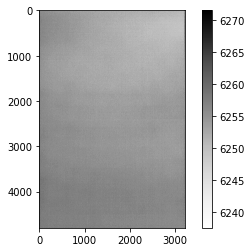

In [9]:
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(MASTER_BIAS["data"], sigma=3.0)

plt.imshow(MASTER_BIAS["data"], cmap='Greys', vmin=bkg_median-5*bkg_sigma, vmax=bkg_median+5*bkg_sigma)
plt.colorbar()

In [10]:
# Master dark
# TBD: check if there is already one that works
darks_list = calibration.load_dark_frames(darks_dir, sc_date, sc_cam, sc_expos, sc_x, sc_y)

DARK (4800x3211) taken in band SDSSgp+ with QHY600M on C2PU/Omicron on 2021-10-15T17:18:12+00:00 (0.3s exposure).
-761 days, 16:01:16
DARK (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T02:46:41+00:00 (0.3s exposure).
1:29:45
DARK (4800x3211) taken in band SDSSgp+ with QHY600M on C2PU/Omicron on 2021-10-15T17:18:05+00:00 (0.3s exposure).
-761 days, 16:01:09
DARK (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T02:46:17+00:00 (0.3s exposure).
1:29:21
DARK (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T02:46:32+00:00 (0.3s exposure).
1:29:36
DARK (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T02:46:35+00:00 (0.3s exposure).
1:29:39
DARK (4800x3211) taken in band SDSSgp+ with QHY600M on C2PU/Omicron on 2021-10-15T17:18:18+00:00 (0.3s exposure).
-761 days, 16:01:22
DARK (4800x3211) taken in band SDSSgp+ with QHY600M on C2PU/Omicron on 2021-10-15T17:18:08+00:00 (0.3s exposure).
-761 days, 16:01:12
DARK

In [11]:
MASTER_DARK, HOT_PIXELS = calibration.master_dark(darks_list, use_bias=False, master_bias=MASTER_BIAS['path'])

DARK (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T02:46:41+00:00 (0.3s exposure).
Number of pixels in the dark: 15412800
Number of hot pixels       :    10181
Fraction of hot pixels (%) : 0.07
Master DARK written to /home/etudiant/Documents/Archives_C2PU/Photometry/CCD__BIAS_DARKS_FLATS/DARKS/QHY600/0.3s/master_dark_2023-11-15_QHY600M_0.300.fits.
Hot pixels map written to /home/etudiant/Documents/Archives_C2PU/Photometry/CCD__BIAS_DARKS_FLATS/DARKS/QHY600/0.3s/bad_pixels_hot_2023-11-15_QHY600M.fits.


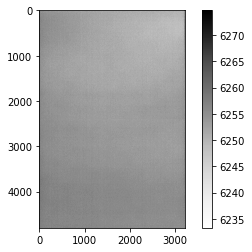

In [12]:
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(MASTER_DARK["data"], sigma=3.0)

plt.imshow(MASTER_DARK["data"], cmap='Greys', vmin=bkg_median-5*bkg_sigma, vmax=bkg_median+5*bkg_sigma)
plt.colorbar()

In [13]:
# Master flat
# TBD: check if there is already one that works
flats_list = calibration.load_flat_frames(flats_dir, sc_date, sc_cam, sc_filter, sc_x, sc_y,\
                                          override_date_check=True)
MASTER_FLAT, DEAD_PIXELS = calibration.master_flat(flats_list, MASTER_DARK["path"])

FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:30:13+00:00 (0.1s exposure).
-848 days, 18:13:17
FLAT (3211x4800) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:30:13+00:00 (0.1s exposure).
-848 days, 18:13:17
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:39+00:00 (0.1s exposure).
-848 days, 18:12:43
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:46+00:00 (0.1s exposure).
-848 days, 18:12:50
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:26+00:00 (0.1s exposure).
-848 days, 18:12:30
FLAT (3211x4800) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:30:13+00:00 (0.1s exposure).
-848 days, 18:13:17
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:15+00:00 (0.1s exposure).
-848 days, 18:12:19
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:02+00:00 (0.1s exposure).
-848

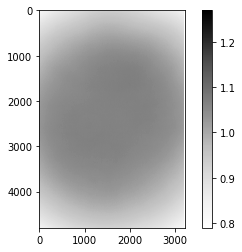

In [14]:
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(MASTER_FLAT["data"], sigma=3.0)

plt.imshow(MASTER_FLAT["data"], cmap='Greys', vmin=bkg_median-5*bkg_sigma, vmax=bkg_median+5*bkg_sigma)
plt.colorbar()

In [15]:
additive_corr = MASTER_DARK["data"] #-MASTER_BIAS["data"]

sc_hdu = fits.open(fits_sci_image)[0]
try:
    RED_SCIENCE = (sc_hdu.data - additive_corr) / MASTER_FLAT["data"]
except ValueError:
    RED_SCIENCE = (np.transpose(sc_hdu.data) - additive_corr) / MASTER_FLAT["data"]

# Clean bad pixels
smoothed = median_filter(RED_SCIENCE, size=(5,5))

# Hot pixels
try:
    hot_pixel = np.where( HOT_PIXELS["data"]==1 )
    RED_SCIENCE[hot_pixel] = smoothed[hot_pixel]
except:
    print('Cannot clean hot pixels')

# Dead pixels
try:
    dead_pixel = np.where( DEAD_PIXELS["data"]==1 )
    RED_SCIENCE[dead_pixel] = smoothed[dead_pixel]
except:
    print('Cannot clean dead pixels')

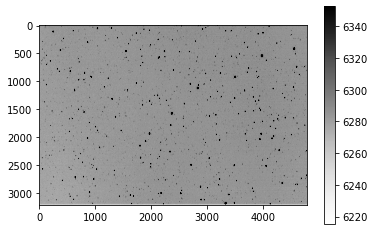

In [16]:
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(sc_hdu.data, sigma=3.0)

plt.imshow(sc_hdu.data, cmap='Greys', vmin=bkg_median-5*bkg_sigma, vmax=bkg_median+5*bkg_sigma)
plt.colorbar()

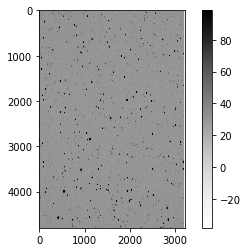

In [17]:
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(RED_SCIENCE, sigma=3.0)

plt.imshow(RED_SCIENCE, cmap='Greys', vmin=bkg_median-5*bkg_sigma, vmax=bkg_median+5*bkg_sigma)
plt.colorbar()

In [18]:
# Write appropriate FITS files
new_fn = f"{sc_im_name}_REDUCED{sc_im_ext}"
red_hdu = sc_hdu.copy()
red_hdu.data = RED_SCIENCE
red_hdu.header["PROCTYPE"] = "RED     "
red_hdu.header["FILENAME"] = new_fn
red_hdu.header["CREATOR"] = "JOCHEVAL"
red_hdu.header["MDARK"] = MASTER_DARK["path"]
red_hdu.header["MFLAT"] = MASTER_FLAT["path"]
red_hdu.header["HPIXELS"] = HOT_PIXELS["path"]
red_hdu.header["DPIXELS"] = DEAD_PIXELS["path"]

write_path = os.path.join(sc_im_dir, new_fn)
red_hdu.writeto(write_path, overwrite=True)
print(f"Calibrated image written to {write_path}.")

dic_to_return = {"path": write_path, "data": RED_SCIENCE,\
                 "MASTER DARK": MASTER_DARK,\
                 "MASTER FLAT": MASTER_FLAT,\
                 "HOT PIXELS": HOT_PIXELS,\
                 "DEAD PIXELS": DEAD_PIXELS\
                }

Calibrated image written to /home/etudiant/Documents/Archives_C2PU/Photometry/Asteroids/2023-11-14_OMICRON_F3p17_OPF_QHY600Ma_9-Metis/9-Metis_20231115T011656474_SC__0000s300_000000_REDUCED.fits.


# Photometry

In [19]:
fits_sci_image = os.path.join('TD_Photometry_python', 'data', 'test_image.fits')
fits_sci_image = os.path.abspath(fits_sci_image)

fits_sci_image = dic_to_return["path"]
sources = photometry.detect_sources(fits_sci_image)

Number of sources detected: 837


In [20]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,1744.0347942056385,12.791898975398183,0.7511733899757439,-0.9253727392979896,-0.6870605128655235,25,0.0,76.74737298252765,1.0174771734506352,-0.018811687112602123
2,886.1893146161108,13.201092909749747,0.6982682560642781,-0.3819379840785799,-0.35296734527465295,25,0.0,82.14066282389804,1.0317607522762573,-0.03394750870260038
3,1352.9215266567223,13.10436195168673,0.7569618445203108,-0.08846455184290206,-0.7547905536814933,25,0.0,96.04796521031712,1.1293169495787347,-0.13203961596212346
4,2717.3144443437163,13.61008272299799,0.2208283578873001,-0.16078808553856788,-0.8560258029048334,25,0.0,110.62538372594373,1.4729574934406902,-0.42047553541867044
5,3063.0398090172644,17.69635246350575,0.25080479871887984,-0.6015433038584523,-0.005771770790094764,25,0.0,114.46449263921744,1.24864090897224,-0.2410938988289183
6,2699.2707438205093,20.18800413818918,0.5955518444062491,-0.31556378887350506,-0.7118498878031148,25,0.0,78.03915160224757,1.0071809325003356,-0.007768738271078456
7,2683.5324932710364,22.075587921693803,0.8624302640673285,0.3119826778515715,0.024017788127524288,25,0.0,119.74714662444687,1.1775670690979934,-0.17746413007484896
8,2910.4962204591657,22.206041534158597,0.8047587869699209,-0.057643801714602295,-0.26891066478662934,25,0.0,102.68830821921708,1.0889133079012612,-0.0924832636713806
9,2839.215834722718,31.50598136532056,0.6967862777013463,0.17059656112204924,0.6365995585573024,25,0.0,83.34173622784873,1.011309187023228,-0.012209881286027745


In [21]:
fwhm = photometry.get_fwhm(fits_sci_image, sources)

the DATE-REF keyword is non-standard. [astropy.wcs.wcs]
the DATE-REF keyword is non-standard. [astropy.wcs.wcs]


In [22]:
phot_table = photometry.apert_photometry(fits_sci_image, sources, fwhm)

In [23]:
phot_table

id,xcenter,ycenter,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub,noise,SNR
,pix,pix,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,1744.0347942056385,12.791898975398183,502.29270346835216,15.06542792587442,281.0800430367434,221.21266043160875,22.41188754809269,9.870327073385415
2,886.1893146161108,13.201092909749747,513.5342604088567,14.901574779958853,278.02298753641116,235.5112728724455,22.661294323335916,10.39266643432291
3,1352.9215266567223,13.10436195168673,561.147495186443,16.05797699693255,299.5983179229117,261.54917726353136,23.68855198585264,11.04116357216493
4,2717.3144443437163,13.61008272299799,1925.1760167436214,30.876767159007827,576.0767689169833,1349.099247826638,43.87682778806624,30.747419898791556
5,3063.0398090172644,17.69635246350575,1770.0336820790778,45.54638941309638,849.7721511391019,920.261530939976,42.071768230953616,21.873611916860405
6,2699.2707438205093,20.18800413818918,693.7043865525553,28.47617445770773,531.2882170673379,162.41616948521744,26.33826848053143,6.166546962085655
7,2683.5324932710364,22.075587921693803,809.4201392540584,31.704363339763194,591.5174700539384,217.90266920012004,28.45031000277604,7.659061331101777
8,2910.4962204591657,22.206041534158597,670.1481669646777,32.430543111060175,605.0660159281651,65.08215103651253,25.887220147491266,2.5140648808836916


In [24]:
phot_sso_table = photometry.query_sso_photometry(fits_sci_image, fwhm)

the DATE-REF keyword is non-standard. [astropy.wcs.wcs]


Number of SSOs predicted: 29


In [25]:
phot_sso_table

id,xcenter,ycenter,sky_center,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub,noise,SNR
,pix,pix,"deg,deg",,,,,,
int64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64
2,2183.096199098746,1441.7526573545877,"97.70944291666665,24.659673055555555",528.387978877134,26.735917382855206,498.81973785112905,29.5682410260049,22.98669134253849,1.2863200094955287
5,3112.8321737238193,1815.85669540292,"97.83789999999999,24.600346666666667",567.3629217655592,29.493802566615113,550.274398811026,17.088522954533232,23.819381221298745,0.7174209437167522
7,1720.4064514442548,1095.3224596769232,"97.64746375,24.710021944444442",623.4625801538004,28.497283152498674,531.6820480869067,91.78053206689378,24.969232670504724,3.6757449969742524
9,1951.8155887307498,864.1578931176001,"97.683515,24.737499722222225",546.6323303231892,29.0485280631627,541.9667837064717,4.665546616717506,23.38016959568919,0.19955144455315393
10,1459.465146569571,1718.1983168336594,"97.60234166666666,24.631865555555557",628.0199401322086,30.93343380101184,577.1340148346967,50.8859252975119,25.060326018075035,2.030537242843923
15,1361.6088734050816,2087.8611843464973,"97.58375208333332,24.584834444444443",673.2402391901044,28.488639962136162,531.5207895862505,141.71944960385383,25.94687339912276,5.461908547665139
19,1440.5515970651231,609.2408143753162,"97.61338416666666,24.77647",602.6329440446128,27.69149140130499,516.6481584942201,85.98478555039276,24.548583340889813,3.5026373765190177
21,945.3850334539375,2023.5048176386713,"97.52494416666664,24.597882777777777",650.1295803166147,27.459068907494586,512.3117848522385,137.81779546437622,25.497638720411242,5.4051199397554806
